In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd

# Chargement des données
data = pd.read_csv("/content/drive/MyDrive/dataset.csv")
french_sentences = data["Français"].tolist()
ln_sentences = data["Lingala"].tolist()

In [ ]:
ln_sentences = data["Lingala"].tolist()
# ln_sentences

In [ ]:
corpus_fr = []
for french_sentence in french_sentences:
  french_sentence = str(french_sentence).split('nan')[0]
  french_sentence = french_sentence.lower()
  if french_sentence:
    corpus_fr.append(french_sentence)

In [ ]:
len(corpus_fr), corpus_fr[0]

(31098, 'au commencement, dieu créa les cieux et la terre.')

In [ ]:
data['Français'].describe()

count                                          31098
unique                                         30825
top       L'Éternel parla encore à Moïse, en disant:
freq                                              22
Name: Français, dtype: object

In [ ]:
corpus_ln = []
for ln_sentence in ln_sentences:
  ln_sentence = str(ln_sentence).split('nan')[0]
  ln_sentence = ln_sentence.lower()
  if ln_sentence:
    corpus_ln.append(ln_sentence)

In [ ]:
len(corpus_ln), corpus_ln[0]
corpus_ln = corpus_ln[:31098]
len(corpus_ln)

31098

In [ ]:
# ln_sentences

In [ ]:
french_sentences = data["Français"].tolist()
len(french_sentences), french_sentences[40000]
# french_sentences[40000].split('')
bool(str(french_sentences[40000]).split('nan')[0])

False

In [ ]:
len(corpus_fr), len(corpus_ln)

(31098, 31098)

In [ ]:
# corpus_ln = corpus_ln[:10000]
# corpus_fr = corpus_fr[:10000]

# Tokenization

In [ ]:
corpus_ln[45]

'yawe nzambe azwaki moto mpe atiaki ye kati na elanga ya edeni mpo na kolona yango mpe kobatela yango.'

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer()

In [ ]:
tokenizer.fit_on_texts(corpus_fr)

In [ ]:
tokenizer.fit_on_texts(corpus_ln)

In [ ]:
len(tokenizer.word_index)

40903

In [ ]:
sequencesLing = tokenizer.texts_to_sequences(corpus_ln)

In [ ]:
sequencesFra = tokenizer.texts_to_sequences(corpus_fr)

In [ ]:
# Adaptation des tokenizers aux données
tokenizer_french = Tokenizer()
tokenizer_french.fit_on_texts(corpus_fr)
fre_seq = tokenizer_french.texts_to_sequences(corpus_fr)

tokenizer_ln = Tokenizer()
tokenizer_ln.fit_on_texts(corpus_ln)
ln_seq = tokenizer_ln.texts_to_sequences(corpus_ln)

# Utilisation du nombre de mots dans le tokenizer pour définir l'embedding
vocab_size_fr = len(tokenizer_french.word_index) + 1
vocab_size_ln = len(tokenizer_ln.word_index) + 1

# Padding
max_length = max(len(seq) for seq in fre_seq + ln_seq)
fr_seq_padded = pad_sequences(fre_seq, maxlen=max_length, padding='post')
ln_seq_padded = pad_sequences(ln_seq, maxlen=max_length, padding='post')


In [ ]:
max_length, tokenizer_ln

(99, <keras.src.preprocessing.text.Tokenizer at 0x7db44976d720>)

In [ ]:
# embedding_dim = 256
# units = 512
embedding_dim = 256
units = 512

# Encoder
encoder_inputs = Input(shape=(max_length,))
enc_emb = Embedding(input_dim=vocab_size_fr, output_dim=embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_length,))
dec_emb_layer = Embedding(input_dim=vocab_size_ln, output_dim=embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(vocab_size_fr, activation='softmax')
output = decoder_dense(decoder_outputs)

# Modèle
model = Model([encoder_inputs, decoder_inputs], output)

# Compilation du modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 99)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 99)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 99, 256)              6009088   ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 99, 256)              4503808   ['input_2[0][0]']             
                                                                                              

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(fr_seq_padded, ln_seq_padded, test_size=0.2, shuffle=True)
# model.fit([X_train, X_train], y_train, validation_data=([X_val, X_val], y_val), epochs=5, batch_size=64)

In [ ]:
len(X_train), len(X_val), len(y_train), len(y_val)

(24878, 6220, 24878, 6220)

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")

X_train shape: (24878, 99)
y_train shape: (24878, 99)
X_val shape: (6220, 99)


In [ ]:
# print(model.get_layer("embedding_4").input_shape)
# print(model.get_layer("embedding_4").output_shape)

In [ ]:
X_train = np.clip(X_train, 0, 11991)
X_val = np.clip(X_val, 0, 11991)

In [ ]:
min_index = 0
X_train -= min_index
X_val -= min_index

In [ ]:
from tensorflow.keras.optimizers.legacy import Adam

In [ ]:
# model.fit([X_train, y_train], X_train, validation_data=([X_val, X_val], X_val), epochs=2, batch_size=16)
model.fit([X_train, X_train], y_train, validation_data=([X_val, X_val], y_val), epochs=2, batch_size=16)

Epoch 1/2
1555/1555 [==============================] - 8379s 5s/step - loss: 1.7214 - accuracy: 0.7600 - val_loss: 1.6748 - val_accuracy: 0.7632
Epoch 2/2
1555/1555 [==============================] - 8396s 5s/step - loss: 1.6627 - accuracy: 0.7622 - val_loss: 1.6720 - val_accuracy: 0.7631


In [ ]:
import string

# Définition de la fonction preprocess_sentence
def preprocess_sentence(sentence):
    # Conversion en minuscules
    sentence = sentence.lower()

    # Suppression de la ponctuation
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))

    return sentence

# Supposons que vous avez une phrase en français que vous souhaitez traduire en anglais
input_sentence = "Dieu créa les cieux et la terre. :"

# Prétraitement de la phrase d'entrée
input_sentence = preprocess_sentence(input_sentence)

# Convertir la phrase en une séquence d'entiers en utilisant le tokenizer français
input_sequence = tokenizer_french.texts_to_sequences([input_sentence])

# Remplir la séquence pour avoir la même longueur que les autres séquences d'entrée
input_sequence = pad_sequences(input_sequence, maxlen=max_length, padding='post')

# Traduction en utilisant le modèle
output_sequence = model.predict([input_sequence, np.zeros((1, max_length))])
output_sequence = np.argmax(output_sequence, axis=-1)

# Convertir la séquence de sortie en une phrase en anglais en utilisant le tokenizer anglais
output_sentence = tokenizer_ln.sequences_to_texts(output_sequence)[0]

# Afficher la traduction
print("Traduction : ", output_sentence)

1/1 [==============================] - 0s 93ms/step
Traduction :  kasi na na na na na


In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(metric):
  """
  Plots the training and validation values of a given metric.

  Args:
    metric: The metric to plot.
  """
  plt.plot(h.history[metric])
  plt.plot(h.history['val_' + metric], linestyle="--")
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend(['Train', 'Validation'])
  plt.show()

In [ ]:
plot_graphs('accuracy')
plot_graphs('loss')

In [ ]:
# embedding_dim = 256
# units = 512
embedding_dim = 256
units = 512

# Encoder
encoder_inputs = Input(shape=(max_length,))
enc_emb = Embedding(input_dim=vocab_size_fr, output_dim=embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(input_dim=vocab_size_fr, output_dim=embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(vocab_size_ln, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# Train the model
# h = model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=batch_size, epochs=epochs, validation_split=validation_split)

# Save the model
# model.save('s2s.h5')

In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 99)]                 0         []                            
                                                                                                  
 input_20 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 embedding_18 (Embedding)    (None, 99, 256)              6009088   ['input_19[0][0]']            
                                                                                                  
 embedding_19 (Embedding)    (None, None, 256)            6009088   ['input_20[0][0]']            
                                                                                            

In [ ]:
# embedding_dim = 256
# units = 512
embedding_dim = 256
units = 512

# Encoder
encoder_inputs = Input(shape=(max_length,))
enc_emb = Embedding(input_dim=vocab_size_fr, output_dim=embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_length,))
dec_emb_layer = Embedding(input_dim=vocab_size_ln, output_dim=embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(vocab_size_fr, activation='softmax')
output = decoder_dense(decoder_outputs)

# Modèle
model = Model([encoder_inputs, decoder_inputs], output)

# Compilation du modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 99)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 99)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 99, 256)              6009088   ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 99, 256)              4503808   ['input_2[0][0]']             
                                                                                              

In [ ]:
h = model.fit([X_train, X_train], y_train, validation_data=([X_val, X_val], y_val), epochs=10, batch_size=16)

Epoch 1/10
1555/1555 [==============================] - 160s 103ms/step - loss: 1.6376 - accuracy: 0.7633 - val_loss: 1.6722 - val_accuracy: 0.7621
Epoch 2/10
1555/1555 [==============================] - 157s 101ms/step - loss: 1.6050 - accuracy: 0.7644 - val_loss: 1.6843 - val_accuracy: 0.7614
Epoch 3/10
1555/1555 [==============================] - 156s 101ms/step - loss: 1.5710 - accuracy: 0.7655 - val_loss: 1.6841 - val_accuracy: 0.7607
Epoch 4/10
1555/1555 [==============================] - 156s 101ms/step - loss: 1.5386 - accuracy: 0.7669 - val_loss: 1.6999 - val_accuracy: 0.7592
Epoch 5/10
1555/1555 [==============================] - 156s 100ms/step - loss: 1.5025 - accuracy: 0.7683 - val_loss: 1.7222 - val_accuracy: 0.7538
Epoch 6/10
1555/1555 [==============================] - 158s 102ms/step - loss: 1.4635 - accuracy: 0.7701 - val_loss: 1.7750 - val_accuracy: 0.7531
Epoch 7/10
1555/1555 [==============================] - 157s 101ms/step - loss: 1.4218 - accuracy: 0.7716 - val_

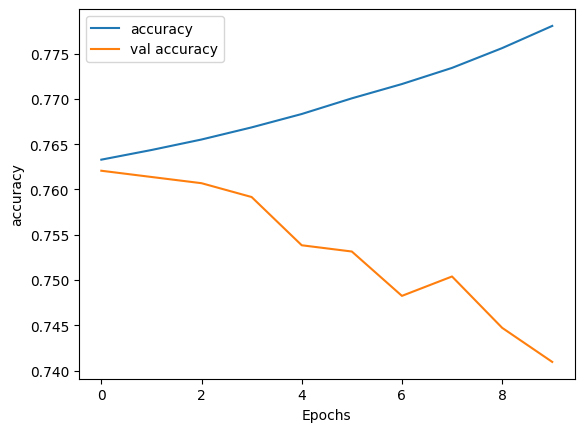

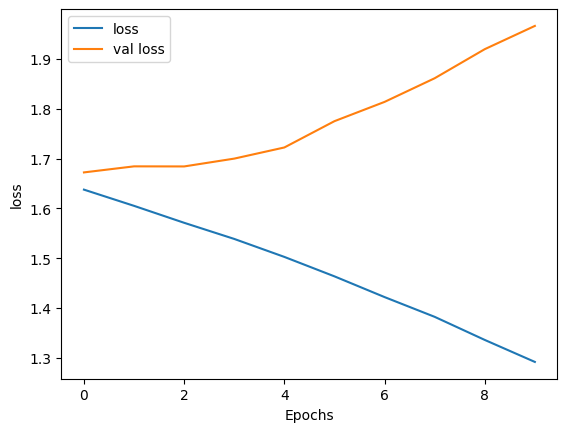

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val '+string])
    plt.show()

plot_graphs(h, 'accuracy')
plot_graphs(h, 'loss')

In [ ]:
import string

# Définition de la fonction preprocess_sentence
def preprocess_sentence(sentence):
    # Conversion en minuscules
    sentence = sentence.lower()

    # Suppression de la ponctuation
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))

    return sentence

# Supposons que vous avez une phrase en français que vous souhaitez traduire en anglais
input_sentence = "ce fut le second jour.. :"

# Prétraitement de la phrase d'entrée
input_sentence = preprocess_sentence(input_sentence)

# Convertir la phrase en une séquence d'entiers en utilisant le tokenizer français
input_sequence = tokenizer_french.texts_to_sequences([input_sentence])

# Remplir la séquence pour avoir la même longueur que les autres séquences d'entrée
input_sequence = pad_sequences(input_sequence, maxlen=max_length, padding='post')

# Traduction en utilisant le modèle
output_sequence = model.predict([input_sequence, np.zeros((1, max_length))])
output_sequence = np.argmax(output_sequence, axis=-1)

# Convertir la séquence de sortie en une phrase en anglais en utilisant le tokenizer anglais
output_sentence = tokenizer_ln.sequences_to_texts(output_sequence)[0]

# Afficher la traduction
print("Traduction : ", output_sentence)

1/1 [==============================] - 0s 24ms/step
Traduction :  pamba na na na na na na na na na na na na na na na na na
